['Simple Filter', 'Group By & Mean', 'Sort Values', 'Multiple Operations', 'Compound Filter', 'Column Operations', 'Window Function', 'Multiple Aggregations', 'Join Operation', 'String Operations', 'Percentile Calculation', 'Complex Combined Filter']


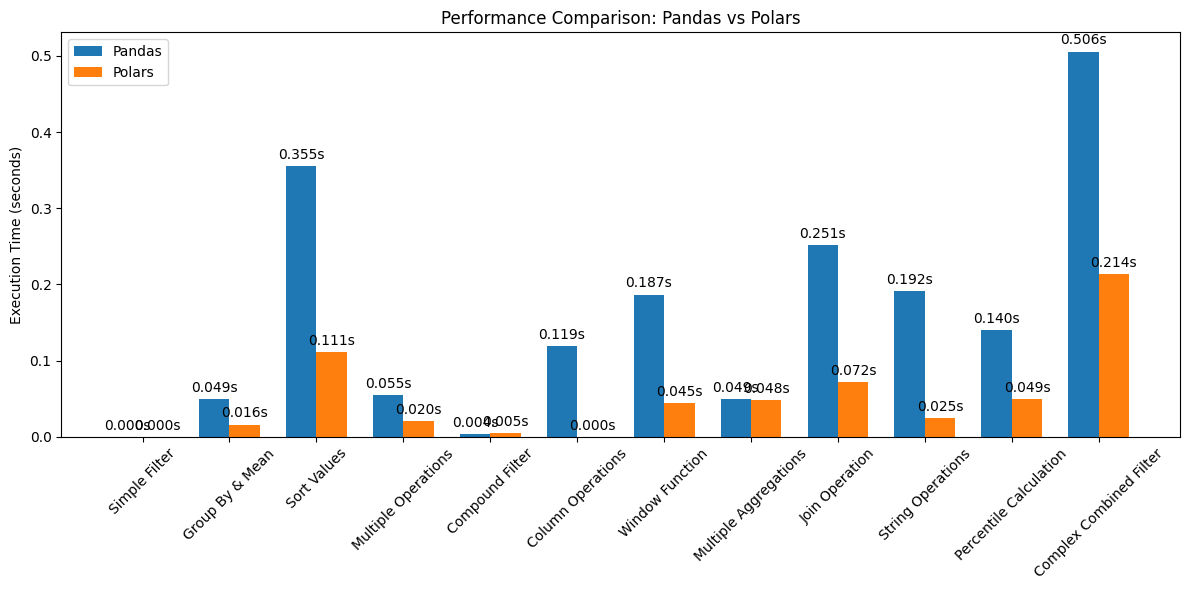

In [ ]:
import polars as pl
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the data
pandas_df = pd.read_csv('datasets/health.csv')
polars_df = pl.read_csv('datasets/health.csv')

pandas_df = pandas_df.rename(columns={
    'Prevalence Rate (%)': 'Prevalence Rate',
    'Incidence Rate (%)': 'Incidence Rate',
    'Mortality Rate (%)': 'Mortality Rate',
    'Healthcare Access (%)': 'Healthcare Access',
    'Recovery Rate (%)': 'Recovery Rate',
    'Urbanization Rate (%)': 'Urbanization Rate',
    'Improvement in 5 Years (%)': 'Improvement in 5 Years'
})

polars_df = polars_df.rename({
    'Prevalence Rate (%)': 'Prevalence Rate',
    'Incidence Rate (%)': 'Incidence Rate',
    'Mortality Rate (%)': 'Mortality Rate',
    'Healthcare Access (%)': 'Healthcare Access',
    'Recovery Rate (%)': 'Recovery Rate',
    'Urbanization Rate (%)': 'Urbanization Rate',
    'Improvement in 5 Years (%)': 'Improvement in 5 Years'
})

# List of operations to test
operations = [
    ('Simple Filter', 
     lambda panda_df: panda_df[panda_df['Prevalence Rate'] > 50],
     lambda polar_df: polar_df.filter(pl.col('Prevalence Rate') > 50)),
    
    ('Group By & Mean', 
     lambda panda_df: panda_df.groupby('Country')['Prevalence Rate'].mean(),
     lambda polar_df: polar_df.group_by('Country').agg(pl.col('Prevalence Rate').mean())),
    
    ('Sort Values', 
     lambda panda_df: panda_df.sort_values('Prevalence Rate', ascending=False),
     lambda polar_df: polar_df.sort('Prevalence Rate', descending=True)),
    
    ('Multiple Operations',
     lambda panda_df: panda_df.groupby('Country').agg({'Prevalence Rate': 'mean', 'Mortality Rate': 'sum'}).sort_values('Prevalence Rate'),
     lambda polar_df: polar_df.group_by('Country').agg([pl.col('Prevalence Rate').mean(), pl.col('Mortality Rate').sum()]).sort('Prevalence Rate')),
    
    ('Compound Filter', 
     lambda panda_df: panda_df[(panda_df['Prevalence Rate'] > 50) & (panda_df['Mortality Rate'] < 30)],
     lambda polar_df: polar_df.filter((pl.col('Prevalence Rate') > 50) & (pl.col('Mortality Rate') < 30))),
    
    ('Column Operations',
     lambda panda_df: panda_df.assign(Risk_Score=panda_df['Prevalence Rate'] * panda_df['Mortality Rate'] / 100),
     lambda polar_df: polar_df.with_columns((pl.col('Prevalence Rate') * pl.col('Mortality Rate') / 100).alias('Risk_Score'))),
    
    ('Window Function',
     lambda panda_df: panda_df.assign(Avg_Prevalence=panda_df.groupby('Country')['Prevalence Rate'].transform('mean')),
     lambda polar_df: polar_df.with_columns(pl.col('Prevalence Rate').mean().over('Country').alias('Avg_Prevalence'))),
    
    ('Multiple Aggregations',
     lambda panda_df: panda_df.groupby('Country').agg({
         'Prevalence Rate': ['mean', 'min', 'max'],
         'Mortality Rate': ['mean', 'min', 'max']}),
     lambda polar_df: polar_df.group_by('Country').agg([
         pl.col('Prevalence Rate').mean().alias('Prevalence Rate mean'),
         pl.col('Prevalence Rate').min().alias('Prevalence Rate min'),
         pl.col('Prevalence Rate').max().alias('Prevalence Rate max'),
         pl.col('Mortality Rate').mean().alias('Mortality Rate mean'),
         pl.col('Mortality Rate').min().alias('Mortality Rate min'),
         pl.col('Mortality Rate').max().alias('Mortality Rate max')
     ])),
    
    ('Join Operation',
     lambda panda_df: panda_df.merge(panda_df.groupby('Country')['Prevalence Rate'].mean().reset_index(), on='Country', suffixes=('', '_country_avg')),
     lambda polar_df: polar_df.join(polar_df.group_by('Country').agg(pl.col('Prevalence Rate').mean().alias('Prevalence_country_avg')), on='Country')),
    
    ('String Operations',
     lambda panda_df: panda_df.assign(Country_Upper=panda_df['Country'].str.upper()),
     lambda polar_df: polar_df.with_columns(pl.col('Country').str.to_uppercase())),
    
    
    ('Percentile Calculation',
     lambda panda_df: panda_df.groupby('Country')['Prevalence Rate'].quantile(0.75),
     lambda polar_df: polar_df.group_by('Country').agg(pl.col('Prevalence Rate').quantile(0.75))), 

    ('Complex Combined Filter',

    lambda panda_df: panda_df[

        ((panda_df['Prevalence Rate'] > panda_df['Prevalence Rate'].mean()) & 
         (panda_df['Mortality Rate'] < panda_df['Mortality Rate'].median())) &

        (panda_df['Healthcare Access'] > panda_df['Healthcare Access'].quantile(0.75)) &

        ((panda_df['Recovery Rate'] > 80) | (panda_df['Improvement in 5 Years'] > 20)) &

        (((panda_df['Prevalence Rate'] * panda_df['Mortality Rate']) / (panda_df['Recovery Rate'] + 1)) < 50) &

        (panda_df['Country'].str.contains('land|^A', case=False)) &
        (((panda_df['Urbanization Rate'] - panda_df['Urbanization Rate'].mean()) / panda_df['Urbanization Rate'].std() > -1))
    ],
    

    lambda polar_df: polar_df.filter(

        (pl.col('Prevalence Rate') > pl.col('Prevalence Rate').mean()) &
        (pl.col('Mortality Rate') < pl.col('Mortality Rate').median()) &

        (pl.col('Healthcare Access') > pl.col('Healthcare Access').quantile(0.75)) &

        ((pl.col('Recovery Rate') > 80) | (pl.col('Improvement in 5 Years') > 20)) &

        (((pl.col('Prevalence Rate') * pl.col('Mortality Rate')) / (pl.col('Recovery Rate') + 1)) < 50) &

        (pl.col('Country').str.to_lowercase().str.contains('land') | 
         pl.col('Country').str.to_lowercase().str.starts_with('a')) &

        (((pl.col('Urbanization Rate') - pl.col('Urbanization Rate').mean()) / pl.col('Urbanization Rate').std() > -1))
    ))
]


pandas_times = []
polars_times = []
operation_names = []


for name, pandas_op, polars_op in operations:
    
    #Pandas 
    start_time = time.time()
    pandas_op(pandas_df)
    pandas_time = time.time() - start_time
    pandas_times.append(pandas_time)
    
    #Polars 
    start_time = time.time()
    polars_op(polars_df)
    polars_time = time.time() - start_time
    polars_times.append(polars_time)
    
    operation_names.append(name)

# print(operation_names, pandas_times, polars_times)

x = np.arange(len(operation_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, pandas_times, width, label='Pandas')
rects2 = ax.bar(x + width/2, polars_times, width, label='Polars')


ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Performance Comparison: Pandas vs Polars')
ax.set_xticks(x)
ax.set_xticklabels(operation_names, rotation=45)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}s',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

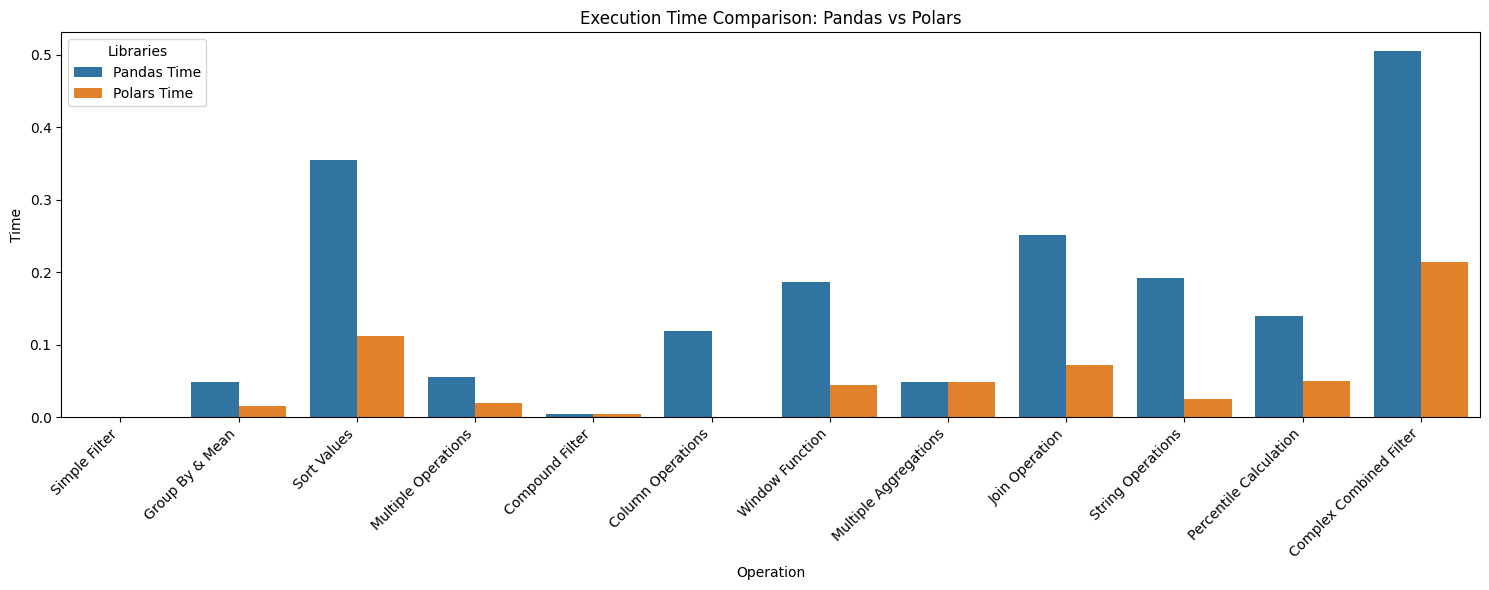

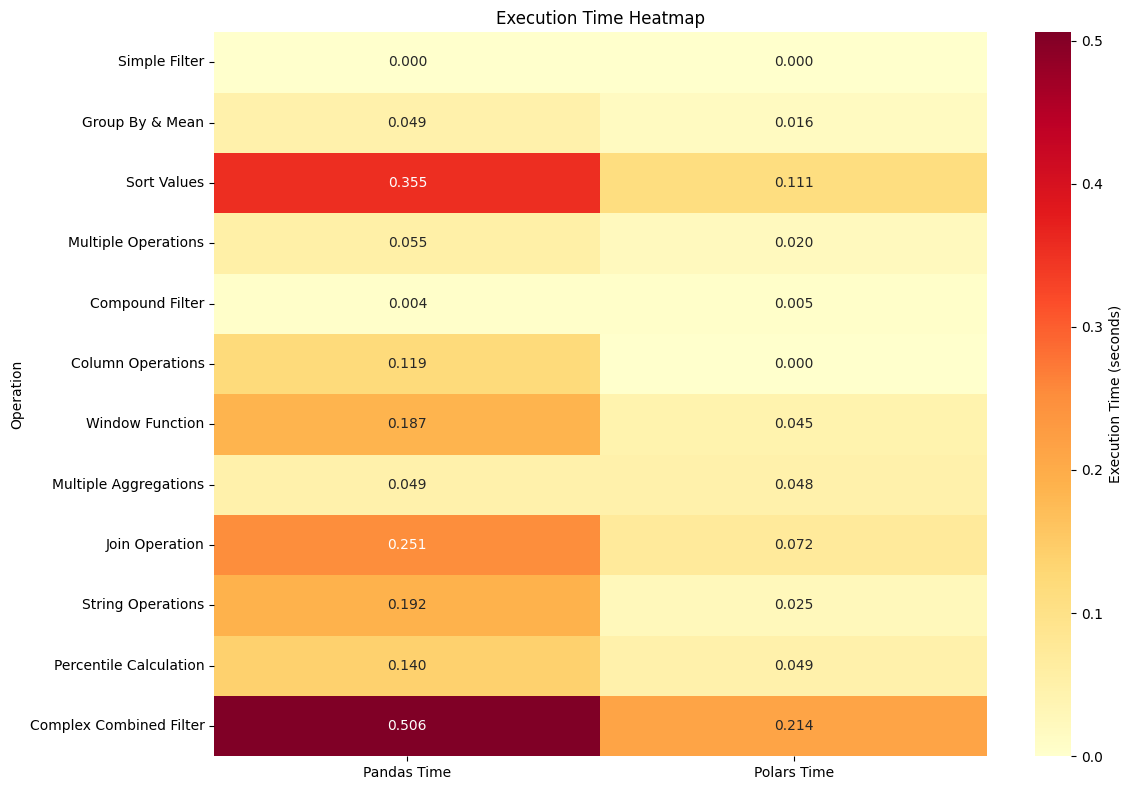

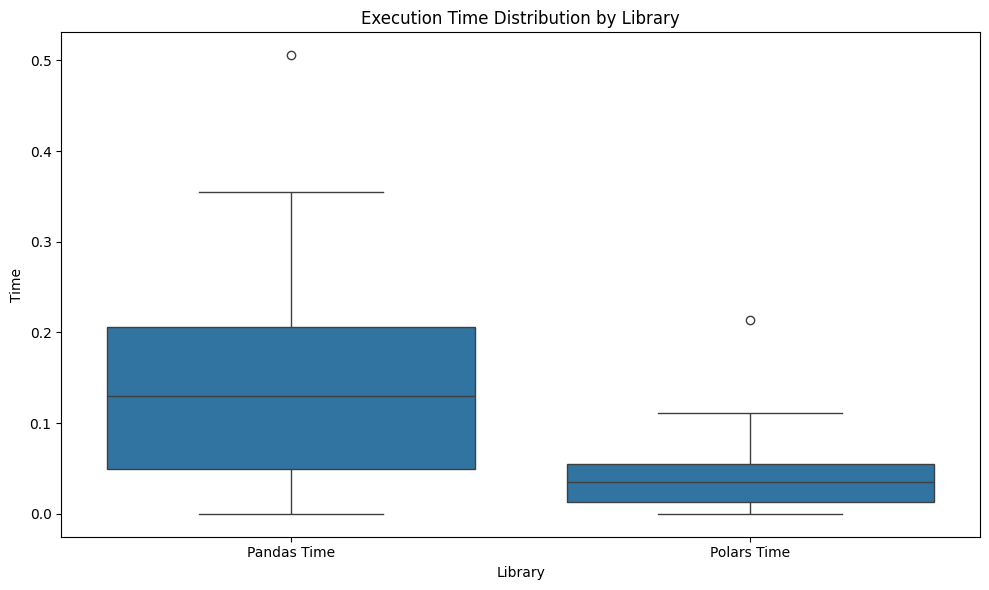

Mean Execution Times:
Pandas Time    0.158913
Polars Time    0.050479
dtype: float64

Median Execution Times:
Pandas Time    0.129672
Polars Time    0.034801
dtype: float64

Mean Speedup Ratio: inf


In [4]:

results_df = pd.DataFrame({
    'Operation': operation_names,
    'Pandas Time': pandas_times,
    'Polars Time': polars_times
})


results_df['Speedup Ratio'] = results_df['Pandas Time'] / results_df['Polars Time']

# Bar plot 
plt.figure(figsize=(15, 6))
sns.barplot(data=results_df.melt(id_vars='Operation', 
                                value_vars=['Pandas Time', 'Polars Time'],
                                var_name='Libraries', 
                                value_name='Time'),
            x='Operation', 
            y='Time',
            hue='Libraries')
plt.xticks(rotation=45, ha='right')
plt.title('Execution Time Comparison: Pandas vs Polars')
plt.tight_layout()
plt.show()

# Heatmap 
plt.figure(figsize=(12, 8))
heatmap_data = results_df.set_index('Operation')[['Pandas Time', 'Polars Time']]
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Execution Time (seconds)'})
plt.title('Execution Time Heatmap')
plt.tight_layout()
plt.show()



#Box plot 
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df.melt(id_vars='Operation', 
                                value_vars=['Pandas Time', 'Polars Time'],
                                var_name='Library', 
                                value_name='Time'),
            x='Library',
            y='Time')
plt.title('Execution Time Distribution by Library')
plt.tight_layout()
plt.show()



print("Mean Execution Times:")
print(results_df[['Pandas Time', 'Polars Time']].mean())
print()
print("Median Execution Times:")
print(results_df[['Pandas Time', 'Polars Time']].median())
print()
print("Mean Speedup Ratio:", results_df['Speedup Ratio'].mean())

In [3]:
print("Pandas columns:", pandas_df.columns.tolist())
print("Polars columns:", polars_df.columns)

Pandas columns: ['Country', 'Year', 'Disease Name', 'Disease Category', 'Prevalence Rate (%)', 'Incidence Rate (%)', 'Mortality Rate (%)', 'Age Group', 'Gender', 'Population Affected', 'Healthcare Access (%)', 'Doctors per 1000', 'Hospital Beds per 1000', 'Treatment Type', 'Average Treatment Cost (USD)', 'Availability of Vaccines/Treatment', 'Recovery Rate (%)', 'DALYs', 'Improvement in 5 Years (%)', 'Per Capita Income (USD)', 'Education Index', 'Urbanization Rate (%)']
Polars columns: ['Country', 'Year', 'Disease Name', 'Disease Category', 'Prevalence Rate (%)', 'Incidence Rate (%)', 'Mortality Rate (%)', 'Age Group', 'Gender', 'Population Affected', 'Healthcare Access (%)', 'Doctors per 1000', 'Hospital Beds per 1000', 'Treatment Type', 'Average Treatment Cost (USD)', 'Availability of Vaccines/Treatment', 'Recovery Rate (%)', 'DALYs', 'Improvement in 5 Years (%)', 'Per Capita Income (USD)', 'Education Index', 'Urbanization Rate (%)']
